In [13]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [ ]:
# define all the input params
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 
AstroParams = zeus21.Astro_Parameters(CosmoParams)
HMFintclass = zeus21.HMF_interpolator(CosmoParams,ClassyCosmo)
ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21 = zeus21.get_T21_coefficients(CosmoParams, ClassyCosmo, AstroParams, HMFintclass, zmin=ZMIN)

In [ ]:
# average SFRD
bar_SFRD = CoeffStructure_21.SFRDbar2D_II

Nsigmad = 5.0 #how many sigmas we explore
Nds = 100 #how many deltas

# define \delta_R
deltatab_norm = np.linspace(-Nsigmad,Nsigmad,Nds)

# this is just for dimensions
zArray, rArray, mArray, deltaNormArray = np.meshgrid(CoeffStructure_21.zintegral, CoeffStructure_21.Rtabsmoo, HMFintclass.Mhtab, deltatab_norm, indexing = 'ij', sparse = True)
# rArray is between 0.5 to 2000 Mpc, for integration 
rGreaterArray = np.zeros_like(zArray) + rArray
rGreaterArray[CosmoParams.chiofzint(zArray) + rArray >= CosmoParams.chiofzint(50)] = np.nan
zGreaterArray = CosmoParams.zfofRint(CosmoParams.chiofzint(zArray) + rGreaterArray)

# variance smoothed over R > Rh
sigmaR = np.zeros((len(CoeffStructure_21.zintegral), len(CoeffStructure_21.Rtabsmoo), 1, 1))
whereNotNans = np.invert(np.isnan(rGreaterArray))
sigmaR[whereNotNans] = HMFintclass.sigmaRintlog((np.log(rGreaterArray)[whereNotNans], zGreaterArray[whereNotNans]))

# variance smoothed over Rh = R(M_h) with Mh between 1e5 and 1e14 
sigmaM = HMFintclass.sigmaintlog((np.log(mArray), zGreaterArray))

In [ ]:
zid = 0
zid1 = 21
Rid = 10

# tilde delta 
deltaArray = deltaNormArray * sigmaR

In [ ]:
# tilde sigma
modSigmaSq = sigmaM**2 - sigmaR**2
indexTooBig = (modSigmaSq <= 0.0)
modSigmaSq[indexTooBig] = np.inf #if sigmaR > sigmaM the halo does not fit in the radius R. Cut the sum
modSigma = np.sqrt(modSigmaSq)

# define the correction from the EPS HMF
nu0 = CosmoParams.delta_crit_ST / sigmaM
nu0[indexTooBig] = 1.0
modd = CosmoParams.delta_crit_ST - deltaArray
nu = modd / modSigma
C_arb = 1.6
EPS_HMF_corr = C_arb * (nu/nu0) * (sigmaM/modSigma)**2.0 * np.exp(-CosmoParams.a_corr_EPS * (nu**2-nu0**2)/2.0 ) * (1.0 + deltaArray)

# integrand of the SFRD
integrand_II = EPS_HMF_corr * zeus21.sfrd.SFRD_II_integrand(AstroParams, CosmoParams, HMFintclass, mArray, zGreaterArray, zGreaterArray)

# SFRD(z|delta_R) / SFRD when z = z[zid] , R = R[Rid]
SFRD_II_dR = np.trapz(integrand_II, HMFintclass.logtabMh, axis = 2)[zid,Rid] / bar_SFRD[zid,Rid]
# SFRD(z|delta_R) / SFRD when z = z[zid1] , R = R[Rid]
SFRD_II_dR1 = np.trapz(integrand_II, HMFintclass.logtabMh, axis = 2)[zid1,Rid] /bar_SFRD[zid1,Rid]

In [ ]:
# exponential approximation when z = z[zid1] , R = R[Rid]
SFRD_deltaR =  np.exp(CoeffStructure_21.gamma_II_index2D [zid,Rid]* deltaArray[zid,Rid,0,:]) 

# exponential approximation when z = z[zid1] , R = R[Rid]
SFRD_deltaR1 =  np.exp(CoeffStructure_21.gamma_II_index2D [zid1,Rid]* deltaArray[zid1,Rid,0,:]) 

In [49]:
# unsmooth SFRD
integrand_II_full = zeus21.sfrd.SFRD_II_integrand(AstroParams, CosmoParams, HMFintclass, mArray, zGreaterArray, zGreaterArray)
SFRD_II_full = np.trapz(integrand_II_full, HMFintclass.logtabMh, axis = 2)[zid,Rid] / bar_SFRD[zid,Rid]
SFRD_II_full_1 = np.trapz(integrand_II_full, HMFintclass.logtabMh, axis = 2)[zid1,Rid] / bar_SFRD[zid1,Rid]

# smooth over delta_R

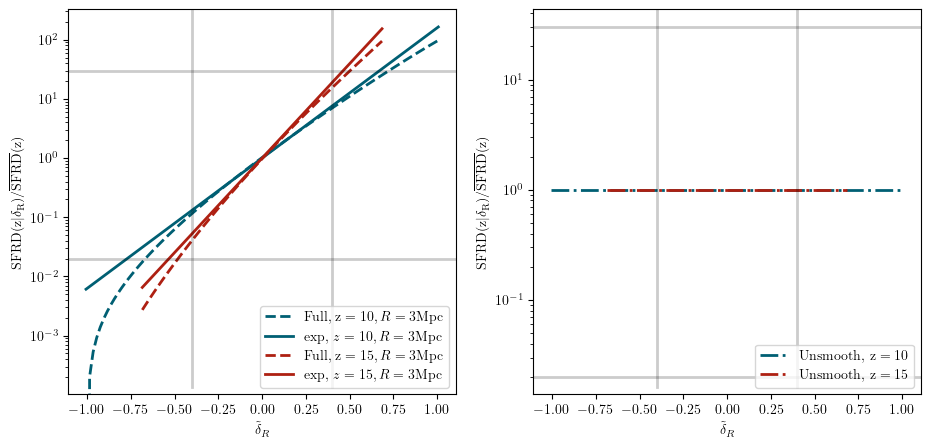

In [51]:
plt.figure(figsize=(11,5))

plt.subplot(121)
plt.semilogy(deltaArray[zid,Rid,0,:],SFRD_II_dR,label=r'$\rm Full,\, z=%g$'%round(CoeffStructure_21.zintegral[zid],0) + r'$, R =%g {\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[1],linestyle='--')
plt.semilogy(deltaArray[zid,Rid,0,:],SFRD_deltaR,label=r'$\exp,\, z=%g$'%round(CoeffStructure_21.zintegral[zid],0) + r'$, R =%g {\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[1])

plt.semilogy(deltaArray[zid1,Rid,0,:],SFRD_II_dR1,label=r'$\rm Full,\, z=%g$'%round(CoeffStructure_21.zintegral[zid1],0) + r'$, R =%g  {\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[-2],linestyle='--')
plt.semilogy(deltaArray[zid1,Rid,0,:],SFRD_deltaR1,label=r'$\exp,\, z=%g$'%round(CoeffStructure_21.zintegral[zid1],0) + r'$, R =%g {\rm Mpc}$'%round(CoeffStructure_21.Rtabsmoo[Rid],0),color=colors[-2])

plt.legend(loc=4)
plt.ylabel(r'$\rm SFRD(z|\delta_R)/\overline{SFRD}(z)$')
plt.xlabel(r'$\tilde{\delta}_R$')

plt.axvline(-0.4,2e-2,3e1,color='k',alpha=0.2)
plt.axvline(0.4,2e-2,3e1,color='k',alpha=0.2)
plt.axhline(2e-2,-1,1,color='k',alpha=0.2)
plt.axhline(3e1,-1,1,color='k',alpha=0.2)

plt.subplot(122)

plt.semilogy(deltaArray[zid,Rid,0,:],SFRD_II_full*np.ones(len(deltaArray[zid,Rid,0,:])),label=r'$\rm Unsmooth,\, z=%g$'%round(CoeffStructure_21.zintegral[zid],0) ,color=colors[1], ls = '-.')

plt.semilogy(deltaArray[zid1,Rid,0,:],SFRD_II_full_1*np.ones(len(deltaArray[zid1,Rid,0,:])),label=r'$\rm Unsmooth,\, z=%g$'%round(CoeffStructure_21.zintegral[zid1],0) ,color=colors[-2],ls='-.')

plt.legend(loc=4)
plt.ylabel(r'$\rm SFRD(z|\delta_R)/\overline{SFRD}(z)$')
plt.xlabel(r'$\tilde{\delta}_R$')

plt.axvline(-0.4,2e-2,3e1,color='k',alpha=0.2)
plt.axvline(0.4,2e-2,3e1,color='k',alpha=0.2)
plt.axhline(2e-2,-1,1,color='k',alpha=0.2)
plt.axhline(3e1,-1,1,color='k',alpha=0.2)